## Análise exploratória de dados - IMDB - 2021:

Análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de dados SQLite. 

Os dados que serão utilizados estão disponíveis no site do IMDB (https://www.imdb.com/interfaces/).

**Perguntas a serem respondidas:**

1. Quais são as categorias de filmes mais comuns no IMDB?
2. Qual o número de títulos por gênero?
3. Qual a mediana de avaliação dos filmes por gênero?
4. Qual a mediana de avaliação dos filmes em relação ao ano de estréia?
5. Qual o número de filmes avaliados por gênero em relação ao ano de estréia?
6. Qual o filme com maior tempo de duração? Calcular os percentis.
7. Qual a relação entre duração e gênero?
8. Qual o número de filmes produzidos por país?
9. Quais são os top 10 melhores filmes?
10. Quai são os top 10 piores filmes?

*Documentações importantes:*

IMDB-SQLite - https://pypi.org/project/imdb-sqlite/ 

Pycountry - https://pypi.org/project/pycountry/

Matplotlib - https://matplotlib.org/stable/users/index.html

### 1. Instalando e Importando 

In [1]:
# Instalando o pacote imdb-sqlite
!pip install -q imdb-sqlite

In [2]:
# Instalando o pacote pycountry 
!pip install -q pycountry

In [3]:
# Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings 
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

### 2. Carregando os Dados

In [4]:
# comando jupyter %% - mede o tempo de excução da célula

In [5]:
%%time 
!imdb-sqlite

Wall time: 5.44 s


2021-07-14 20:05:43,070 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
# Conectando o banco de dados 
conn = sqlite3.connect("imdb.db")

In [7]:
# Extraindo a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Convertendo o df em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [9]:
# Usando um 'for' para percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




### 3. Análise exploratória

### Quais são as categorias de filmes mais comuns no IMDB?

In [10]:
# Criando uma consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [11]:
# Extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

resultado1

,type,COUNT
0,movie,582234
1,radioEpisode,1
2,radioSeries,1
3,short,820435
4,tvEpisode,5911778
5,tvMiniSeries,38285
6,tvMovie,132085
7,tvSeries,210679
8,tvShort,10148
9,tvSpecial,33315


In [12]:
# Calculando o percentual do resultado1
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum())*100

resultado1

,type,COUNT,percentual
0,movie,582234,7.204606
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,820435,10.152123
4,tvEpisode,5911778,73.152777
5,tvMiniSeries,38285,0.473741
6,tvMovie,132085,1.634430
7,tvSeries,210679,2.606957
8,tvShort,10148,0.125572
9,tvSpecial,33315,0.412242


In [13]:
# Gráfico dos resultados obtidos, sendo: 3 categorias com mais títulos e 1 categoria com o restante

# Criar um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Gravar o percentual 
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajustar o nome
others['type'] = 'others'

# Visualiza
others

{'COUNT': 766966, 'percentual': 9.490493803496987, 'type': 'others'}

In [14]:
# Filtrando o df de resultados
resultado1 = resultado1[resultado1['percentual'] > 5]

In [15]:
# Append com o df de 'others'- acrescentar na lista
resultado1 = resultado1.append(others, ignore_index = True)

In [16]:
# Ordenar os resultados do maior para o menor
resultado1 = resultado1.sort_values(by='COUNT', ascending = False)

resultado1.head()

,type,COUNT,percentual
2,tvEpisode,5911778,73.152777
1,short,820435,10.152123
3,others,766966,9.490494
0,movie,582234,7.204606


In [17]:
# Definindo os labels - list comprehension
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

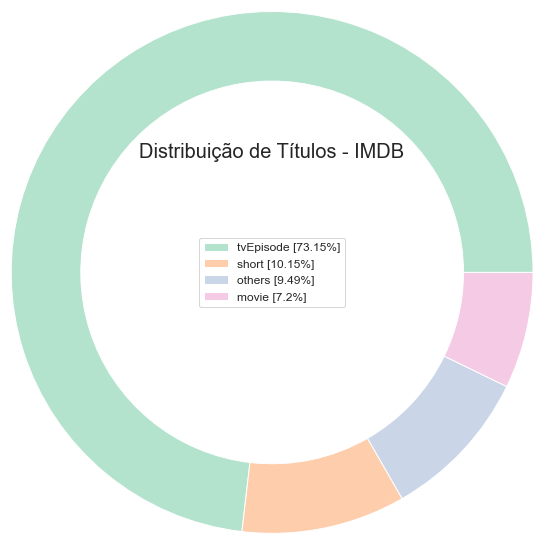

In [18]:
# Plotando o gráfico

# Mapa de cores: https://matplotlib.org/stable/tutorials/colors/colormaps
cs = cm.Pastel2(np.arange(100))

# Criar a figura 
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos - IMDB", loc = 'center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show()

### Qual o número de títulos por gênero?

In [19]:
# Consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [20]:
# Resultado 
resultado2 = pd.read_sql_query(consulta2, conn)

resultado2

,genres,COUNT(*)
0,Action,13246
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1438,"Thriller,Western",36
1439,War,1249
1440,"War,Western",9
1441,Western,4050


In [21]:
# Convertendo as strings para minúsculo - usando 'str.lower'
resultado2['genres'] = resultado2['genres'].str.lower().values

In [22]:
# Removendo os NA's
temp = resultado2['genres'].dropna()

**Countvectorizer** para converter a coluna de gêneros em um valor one-hot encoded para conta o número de filmes em cada gênero

In [23]:
# Criando um vetor usando expressão regular para filtrar as strings

padrao = '(?u)\\b[\\w-]+\\b'

vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [24]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [25]:
# Aplicando a vetorização ao dataset sem os valores NA (matriz esparsa)
bag_generos = vetor.transform(temp)

In [26]:
# Retornando gêneros únicos - (nome dos atributos)
generos_unicos = vetor.get_feature_names()

In [27]:
# Criando o df de generos
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [28]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1442
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1443 non-null   int64
 1   adult        1443 non-null   int64
 2   adventure    1443 non-null   int64
 3   animation    1443 non-null   int64
 4   biography    1443 non-null   int64
 5   comedy       1443 non-null   int64
 6   crime        1443 non-null   int64
 7   documentary  1443 non-null   int64
 8   drama        1443 non-null   int64
 9   family       1443 non-null   int64
 10  fantasy      1443 non-null   int64
 11  film-noir    1443 non-null   int64
 12  game-show    1443 non-null   int64
 13  history      1443 non-null   int64
 14  horror       1443 non-null   int64
 15  music        1443 non-null   int64
 16  musical      1443 non-null   int64
 17  mystery      1443 non-null   int64
 18  n            1443 non-null   int64
 19  news         1443 non-null   int64
 20  reality-

In [29]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [30]:
# Calculando o percentual dos generos
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

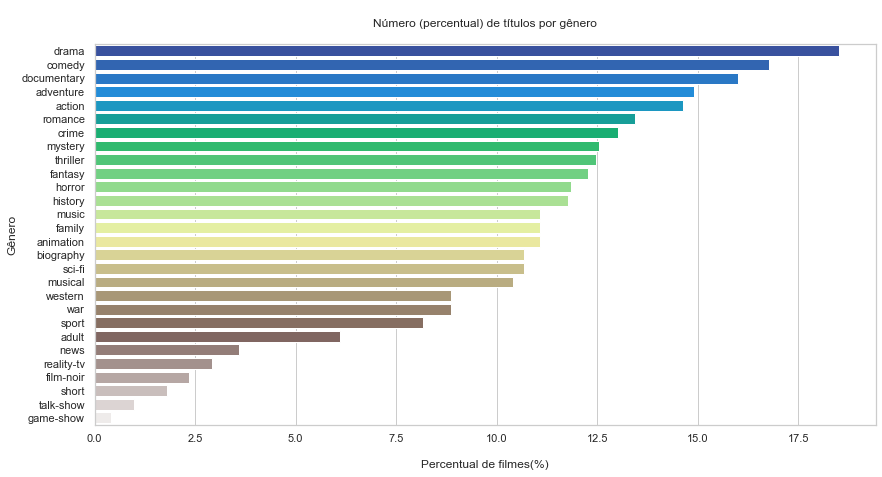

In [31]:
# Platando o gráfico 
plt.figure(figsize = (14,7))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')
plt.xlabel("\nPercentual de filmes(%)")
plt.title('\nNúmero (percentual) de títulos por gênero\n')
plt.show()

### Qual a mediana de avaliação dos filmes por gênero?

In [32]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM ratings 
            JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie'
            '''

In [33]:
resultado3 = pd.read_sql_query(consulta3, conn)

resultado3

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
265829,3.6,"Action,Adventure,Thriller"
265830,5.7,Thriller
265831,6.3,"Adventure,Drama,History"
265832,3.8,"Adventure,History,War"


In [34]:
# Criando uma função para retornar os gêneros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre)>1]
    return generos_unicos

In [35]:
generos_unicos = retorna_generos(resultado3)

generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [36]:
# Listas vazias para contagem do numero de generos e avaliações
genero_counts = []
genero_ratings = []

In [37]:
# Loop
for item in generos_unicos:
    
    # Retornar contagem de filmes por genero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE' +'\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    # Retornar a avaliação de filmes por genero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE'+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating'])) #calculo da mediana de avaliaçao

In [38]:
# df dos generos/avaliações
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

df_genero_ratings.head(20)

,genres,count,rating
0,action,28514,5.8
1,adult,4074,5.8
2,adventure,17530,6.0
3,animation,4620,6.4
4,biography,7968,7.0
5,comedy,66363,6.0
6,crime,22934,6.1
7,documentary,38842,7.3
8,drama,118041,6.3
9,family,10121,6.3


In [39]:
# Drop do índice 18 - para retirar o genero 'news'
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [40]:
# Ordenando o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

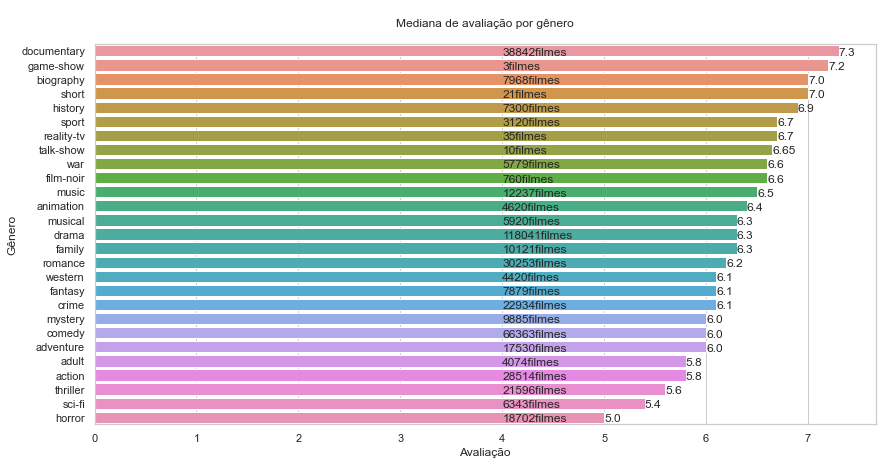

In [41]:
# Plotando o gráfico

# tamanho da figura
plt.figure(figsize = (14,7))

# barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
             i + 0.30,
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + "filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.30,
             round(df_genero_ratings['rating'][df_genero_ratings.index[i]], 2))
    
plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana de avaliação por gênero\n')
plt.show()

### Qual a mediana de avaliação dos filmes em relação ao ano de estréia?

In [42]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type ='movie'
            ORDER BY premiered
            '''

In [43]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

resultado4

,Rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
265829,6.6,2021
265830,4.8,2021
265831,8.3,2021
265832,6.0,2021


In [44]:
# Calculo da mediana ao longo do tempo 
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [45]:
ratings[1:10]

[4.4, 3.8, 6.15, 4.5, 3.5, 4.6, 5.4, 4.3, 3.6]

In [46]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [47]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

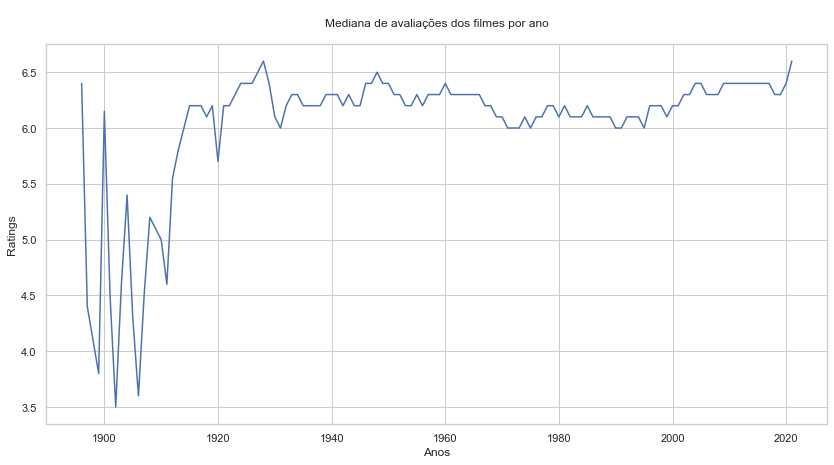

In [48]:
# Plotando o gráfico

plt.figure(figsize = (14,7))
plt.plot(anos, ratings)
plt.xlabel('Anos')
plt.ylabel('Ratings')
plt.title("\nMediana de avaliações dos filmes por ano\n")
plt.show()

Ao observar o gráfico, é possível afirmar que a mediana de avaliações é maior a partir dos anos 2000.

### Qual o número de filmes avaliados por gênero em relação ao ano de estréia?

In [49]:
# Consulta SQL - selecionando todos os generos
consulta5 = ''' SELECT genres FROM titles '''

In [50]:
resultado5 = pd.read_sql_query(consulta5, conn)

resultado5

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8081408,"Action,Drama,Family"
8081409,"Action,Drama,Family"
8081410,"Action,Drama,Family"
8081411,Short


In [51]:
# Retorna apenas generos unicos - filtrando
generos_unicos = retorna_generos(resultado5)

In [52]:
# Generos unicos  
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [53]:
# Contagem para cada genero
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE'+'\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [54]:
# Dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [55]:
# Calculo dos top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

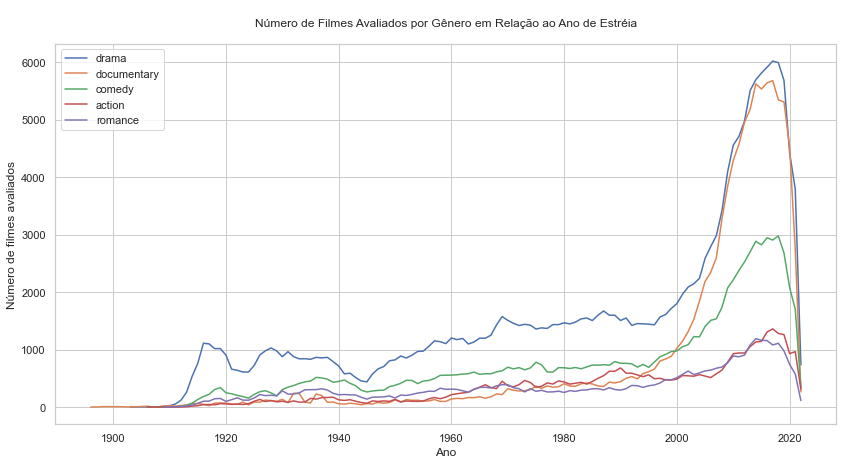

In [56]:
# Plotando o gráfico

plt.figure(figsize = (14,7))

# Loop e plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])


plt.xlabel('Ano')
plt.ylabel('Número de filmes avaliados')
plt.title('\nNúmero de Filmes Avaliados por Gênero em Relação ao Ano de Estréia\n')
plt.legend(labels=top_generos)
plt.show()

### Qual o filme com maior tempo de duração? Calcular os percentis.

In [57]:
# Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

In [58]:
resultado6 = pd.read_sql_query(consulta6, conn)

resultado6

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
366532,123
366533,57
366534,100
366535,116


In [59]:
# Loop para cálculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [60]:
# Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type='movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''

In [61]:
resultado6 = pd.read_sql_query(consulta6, conn)

resultado6

,Runtime,primary_title
0,51420,Logistics


### Qual a relação entre duração e gênero?

In [62]:
# Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE type='movie'
            AND runtime_minutes !='NaN'
            GROUP BY genres
            '''

In [63]:
resultado7 = pd.read_sql_query(consulta7, conn)

resultado7

,Runtime,genres
0,99.403365,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1356,90.333333,"Thriller,Western"
1357,93.466321,War
1358,98.000000,"War,Western"
1359,72.066452,Western


In [64]:
# Generos unicos
generos_unicos = retorna_generos(resultado7)

generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [65]:
# Cálculo da duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM titles WHERE genres LIKE'+'\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime !=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [66]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre']= generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [67]:
# Drop do genero 'new'
df_genero_runtime = df_genero_runtime.drop(index=18)

In [68]:
# Ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by ='runtime', ascending = False)

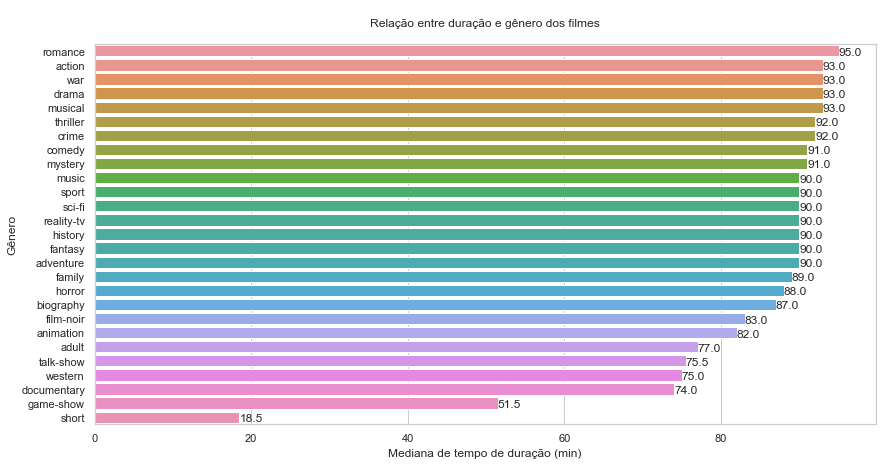

In [69]:
# Plot

plt.figure(figsize =(14,7))

# barplot
sns.barplot(y= df_genero_runtime.genre, x=df_genero_runtime.runtime, orient ="h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
            i + 0.30,
            round(df_genero_runtime['runtime'][df_genero_runtime.index[i]], 2))

plt.xlabel('Mediana de tempo de duração (min)')
plt.ylabel('Gênero')
plt.title('\nRelação entre duração e gênero dos filmes\n')
plt.show()

O gênero romance é o gênero que possui o maior tempo de duração de filme.

### Qual o número de filmes produzidos por país?

In [70]:
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM
            akas JOIN titles ON
            akas.title_id=titles.title_id
            WHERE region !='None'
            AND type =\'movie\'
            GROUP BY region
            '''

In [71]:
resultado8 = pd.read_sql_query(consulta8, conn)

resultado8

,region,Number_of_movies
0,AD,22
1,AE,320
2,AF,108
3,AG,12
4,AL,1230
...,...,...
227,YUCS,146
228,ZA,2943
229,ZM,11
230,ZRCD,2


In [72]:
# Shape
resultado8.shape

(232, 2)

In [73]:
# Número de linhass 
resultado8.shape[0]

232

In [74]:
# Listas
nomes_paises = []
contagem = []

In [75]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except:
        continue

In [76]:
# Dataframes
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [77]:
df_filmes_paises = df_filmes_paises.sort_values(by='Movie_Count', ascending = False)

df_filmes_paises.head(10)

,country,Movie_Count
198,United States,256849
65,United Kingdom,114029
96,Japan,87840
63,France,81092
89,India,70918
32,Canada,67651
47,Germany,65507
93,Italy,63082
26,Brazil,61885
58,Spain,61776


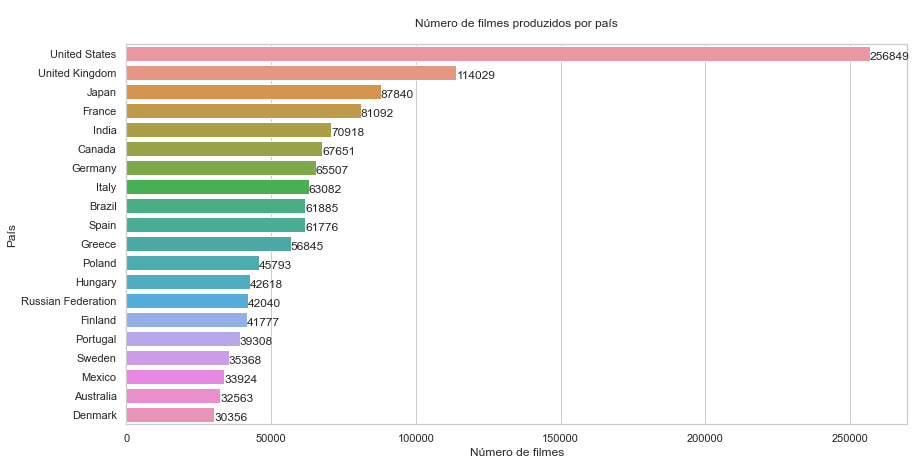

In [78]:
# Plot

plt.figure(figsize =(14,7))

# barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]] -1,
            i + 0.30,
            round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]], 2))
    
plt.ylabel('País')
plt.xlabel('Número de filmes')
plt.title('\nNúmero de filmes produzidos por país\n')
plt.show()

### Quais são os top 10 melhores filmes?

In [79]:
# Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM
            titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type ='movie' AND ratings.votes >=25000
            ORDER BY rating DESC
            LIMIT 10
            '''

In [80]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [81]:
top10_melhores_filmes

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,Dara of Jasenovac,"Drama,War",9.0
9,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0


### Quais são os top 10 piores filmes?

In [82]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM
            titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type ='movie' AND ratings.votes >=25000
            ORDER BY rating ASC
            LIMIT 10
            '''

In [83]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [84]:
top10_piores_filmes

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: the Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
